# Covid-19 SEIRD model for Belo Horizonte
(SEIRD) Suscetible - Exposed - Infected - Recovered - Death

In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [2]:
from readData import read_data
from graphs.plot_graphs import plot_graph
from brasil.covid_brasil import *
from belo_horizonte.covid_bh import *
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go

In [3]:
df_srag = read_data('INFLUD-08-02-2021.csv')

## LMFIT (A python tool for model fitting)

In [4]:
%%capture
import sys
!{sys.executable} -m pip install lmfit

In [5]:
%%capture
!{sys.executable} -m pip install matplotlib

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, report_fit
from scipy.integrate import odeint
from model_seird.params import create_params
from model_seird.run_model import run_model
from model_seird.residual import get_residual
from model_seird.derivative import deriv

## Model fitting: infected population

In [7]:
incubation_time = 5.0      # Incubation period of five days (1 to 12 days, but 5 days on average)
infective_time = 3.0                 # Infectious period may start 1 to 3 days before you develop symptoms
gamma = 1.0 / infective_time         # Recovery rate
delta = 1.0 / incubation_time        # Incubation period
R_0 = 4.0                            # Basic reproductive number
beta = R_0 * gamma                   # Infection rate: R_0 = beta / gamma, so beta = R_0 * gamma
tay = 0.26                           # Brasil's death rate
khi = 1/18                           # On average, 18 days from infection to death

N = 2_722_000                        # Belo Horizonte population

S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0 # initial conditions: one hundred exposed

In [8]:
params = create_params(S0, E0, I0, R0, D0, N, beta, gamma, delta, tay, khi)

In [9]:
df_bh_infected = infected_population_covid_bh(df_srag)

In [10]:
plot_graph(df_bh_infected, 'DT_SIN_PRI', 'SUM', 'Data do início dos sintomas x Confirmação diagnóstico Covid-19 em BH', 'Data dos primeiros sintomas', 'Número de pacientes confirmados com Covid-19')

In [11]:
data = df_bh_infected['SUM'][:220]       # Belo Horizonte
days = len(data.index)
x = np.linspace(0, days-1, days)[:220]

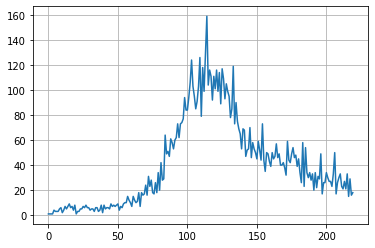

In [12]:
plt.plot(x, data)
plt.grid('True')

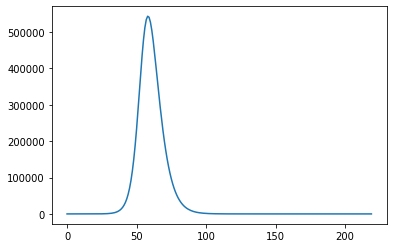

In [13]:
dS, dE, dI, dR, dD = run_model(params, x)
plt.plot(dI)

In [14]:
out = minimize(get_residual, params, args=(data, x))

In [15]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
S0,2721999.00,0.00000000,(0.00%),2721999,-inf,inf,False
E0,1.00000000,0.00000000,(0.00%),1,-inf,inf,False
I0,0.00000000,0.00000000,,0,-inf,inf,False
R0,0.00000000,0.00000000,,0,-inf,inf,False
D0,0.00000000,0.00000000,,0,-inf,inf,False
N,2722000.00,0.00000000,(0.00%),2722000,-inf,inf,False
beta,502.398018,6.03851978,(1.20%),1.3333333333333333,-inf,inf,True
gamma,425.270408,4.05675344,(0.95%),0.3333333333333333,-inf,inf,True
delta,0.20000000,0.00000000,(0.00%),0.2,-inf,inf,False
tay,0.26000000,0.00000000,(0.00%),0.26,-inf,inf,False


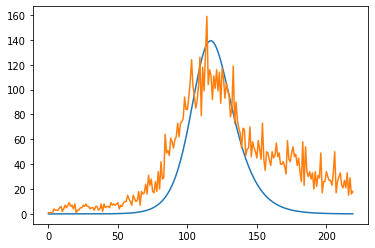

In [16]:
dS, dE, dI, dR, dD = run_model(out.params, x)
plt.plot(dI)
plt.plot(data)

In [17]:
report_fit(out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 103
    # data points      = 220
    # variables        = 2
    chi-square         = 131913.843
    reduced chi-square = 605.109370
    Akaike info crit   = 1411.18088
    Bayesian info crit = 1417.96814
[[Variables]]
    S0:     2721999 (fixed)
    E0:     1 (fixed)
    I0:     0 (fixed)
    R0:     0 (fixed)
    D0:     0 (fixed)
    N:      2722000 (fixed)
    beta:   502.398018 +/- 6.03851978 (1.20%) (init = 1.333333)
    gamma:  425.270408 +/- 4.05675344 (0.95%) (init = 0.3333333)
    delta:  0.2 (fixed)
    tay:    0.26 (fixed)
    khi:    0.05555556 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.960


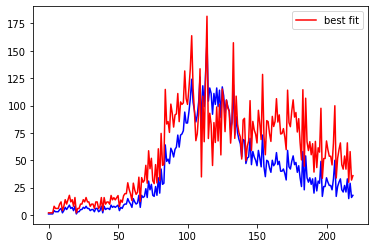

In [18]:
plt.plot(x, data, 'b')
plt.plot(x, get_residual(out.params, data, x) + data, 'r', label='best fit')
plt.legend(loc='best')
plt.show()

In [19]:
S0 = out.params['S0'].value
E0 = out.params['E0'].value
I0 = out.params['I0'].value
R0 = out.params['R0'].value
D0 = out.params['D0'].value
N = out.params['N'].value
beta = out.params['beta'].value
gamma = out.params['gamma'].value
delta = out.params['delta'].value
tay = out.params['tay'].value
khi = out.params['khi'].value

y0 = S0, E0, I0, R0, D0

ret = odeint(deriv, y0, x, args=(N, beta, gamma, delta, tay, khi))
dS, dE, dI, dR, dD = ret.T

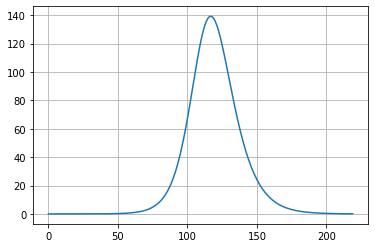

In [20]:
plt.plot(x, dI)
plt.grid('True')

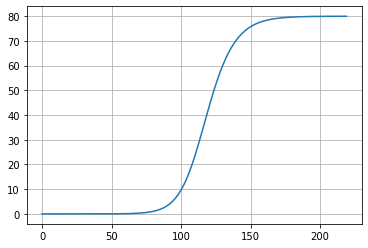

In [21]:
plt.plot(x, dD)
plt.grid('True')

## Model fitting: UTI Covid-19 infected population

In [22]:
incubation_time = 5.0      # Incubation period of five days (1 to 12 days, but 5 days on average)
infective_time = 3.0                 # Infectious period may start 1 to 3 days before you develop symptoms
gamma = 1.0 / infective_time         # Recovery rate
delta = 1.0 / incubation_time        # Incubation period
R_0 = 4.0                            # Basic reproductive number
beta = R_0 * gamma                   # Infection rate: R_0 = beta / gamma, so beta = R_0 * gamma
tay = 0.26                           # Brasil's death rate
khi = 1/18                           # On average, 18 days from infection to death

N = 2_722_000                        # Belo Horizonte population

S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0 # initial conditions: one hundred exposed

In [23]:
params = create_params(S0, E0, I0, R0, D0, N, beta, gamma, delta, tay, khi)

In [24]:
df_bh_uti = uti_data_covid_bh(df_srag)

In [25]:
plot_graph(df_bh_uti, 'DT_ENTUTI', 'SUM', 'Soma de Pessoas que deram entrada em UTI por data na rede SUS de Belo Horizonte', 'Data de entrada na UTI', 'Número de entradas de pacientes em UTI')

In [26]:
data = df_bh_uti['SUM'][:220]       # Belo Horizonte
days = len(data.index)
x = np.linspace(0, days-1, days)[:220]

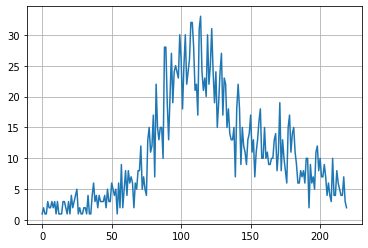

In [27]:
plt.plot(x, data)
plt.grid('True')

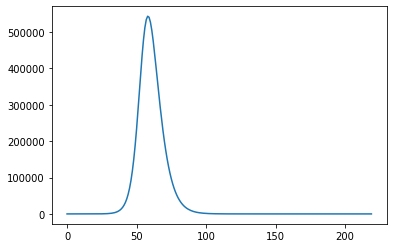

In [28]:
dS, dE, dI, dR, dD = run_model(params, x)
plt.plot(dI)

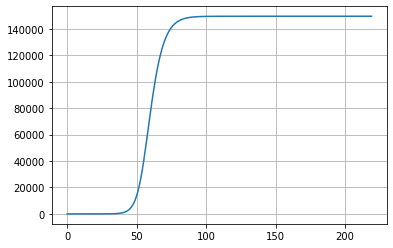

In [29]:
plt.plot(dD)
plt.grid('True')

In [30]:
out = minimize(get_residual, params, args=(data, x))

In [31]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
S0,2721999.00,0.00000000,(0.00%),2721999,-inf,inf,False
E0,1.00000000,0.00000000,(0.00%),1,-inf,inf,False
I0,0.00000000,0.00000000,,0,-inf,inf,False
R0,0.00000000,0.00000000,,0,-inf,inf,False
D0,0.00000000,0.00000000,,0,-inf,inf,False
N,2722000.00,0.00000000,(0.00%),2722000,-inf,inf,False
beta,2559.61936,96.7668066,(3.78%),1.3333333333333333,-inf,inf,True
gamma,2110.59728,69.9918445,(3.32%),0.3333333333333333,-inf,inf,True
delta,0.20000000,0.00000000,(0.00%),0.2,-inf,inf,False
tay,0.26000000,0.00000000,(0.00%),0.26,-inf,inf,False


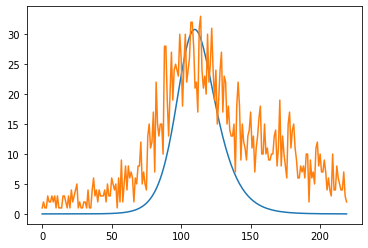

In [32]:
dS, dE, dI, dR, dD = run_model(out.params, x)
plt.plot(dI)
plt.plot(data)

In [33]:
report_fit(out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 121
    # data points      = 220
    # variables        = 2
    chi-square         = 12638.6588
    reduced chi-square = 57.9754989
    Akaike info crit   = 895.195361
    Bayesian info crit = 901.982616
[[Variables]]
    S0:     2721999 (fixed)
    E0:     1 (fixed)
    I0:     0 (fixed)
    R0:     0 (fixed)
    D0:     0 (fixed)
    N:      2722000 (fixed)
    beta:   2559.61936 +/- 96.7668066 (3.78%) (init = 1.333333)
    gamma:  2110.59728 +/- 69.9918445 (3.32%) (init = 0.3333333)
    delta:  0.2 (fixed)
    tay:    0.26 (fixed)
    khi:    0.05555556 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.993


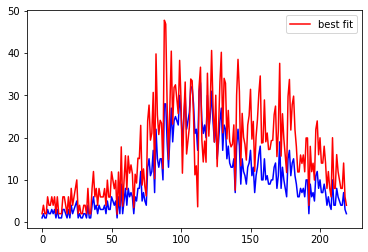

In [34]:
plt.plot(x, data, 'b')
plt.plot(x, get_residual(out.params, data, x) + data, 'r', label='best fit')
plt.legend(loc='best')
plt.show()

In [35]:
S0 = out.params['S0'].value
E0 = out.params['E0'].value
I0 = out.params['I0'].value
R0 = out.params['R0'].value
D0 = out.params['D0'].value
N = out.params['N'].value
beta = out.params['beta'].value
gamma = out.params['gamma'].value
delta = out.params['delta'].value
tay = out.params['tay'].value
khi = out.params['khi'].value

y0 = S0, E0, I0, R0, D0

ret = odeint(deriv, y0, x, args=(N, beta, gamma, delta, tay, khi))
dS, dE, dI, dR, dD = ret.T

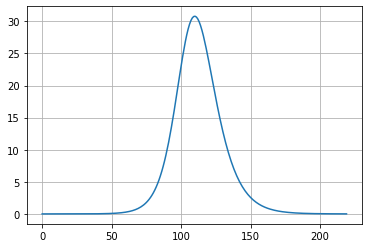

In [36]:
plt.plot(x, dI)
plt.grid('True')

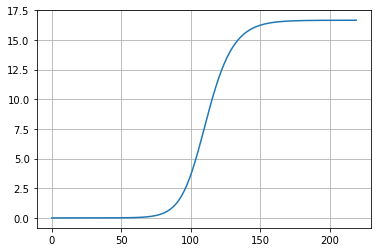

In [37]:
plt.plot(x, dD)
plt.grid('True')

## Model fitting: UTI death covid-19

In [38]:
incubation_time = 5.0      # Incubation period of five days (1 to 12 days, but 5 days on average)
infective_time = 3.0                 # Infectious period may start 1 to 3 days before you develop symptoms
gamma = 1.0 / infective_time         # Recovery rate
delta = 1.0 / incubation_time        # Incubation period
R_0 = 4.0                            # Basic reproductive number
beta = R_0 * gamma                   # Infection rate: R_0 = beta / gamma, so beta = R_0 * gamma
tay = 0.26                           # Brasil's death rate
khi = 1/18                           # On average, 18 days from infection to death

N = 2_722_000                        # Belo Horizonte population

S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0 # initial conditions: one hundred exposed

In [39]:
params = create_params(S0, E0, I0, R0, D0, N, beta, gamma, delta, tay, khi)

In [40]:
df_bh_death_infected_uti = uti_deaths_covid_bh(df_srag)

In [41]:
plot_graph(df_bh_death_infected_uti, 'DT_ENTUTI', 'SUM', 'Data do início dos sintomas x Falecimento por Covid-19 em BH na UTI', 'Data dos primeiros sintomas', 'Número de pacientes falecidos por Covid-19')

In [42]:
data = df_bh_death_infected_uti['SUM'][:220] # Belo Horizonte
days = len(data.index)
x = np.linspace(0, days-1, days)[:220]

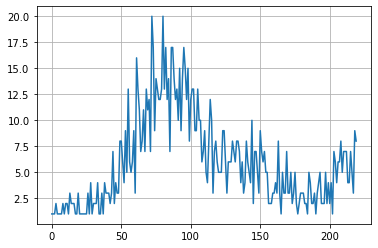

In [43]:
plt.plot(x, data)
plt.grid('True')

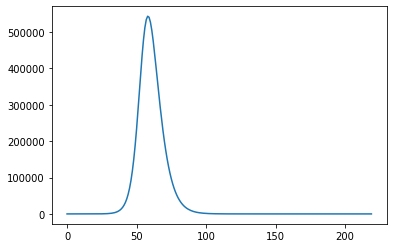

In [44]:
dS, dE, dI, dR, dD = run_model(params, x)
plt.plot(dI)

In [45]:
out = minimize(get_residual, params, args=(data, x))

In [46]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
S0,2721999.00,0.00000000,(0.00%),2721999,-inf,inf,False
E0,1.00000000,0.00000000,(0.00%),1,-inf,inf,False
I0,0.00000000,0.00000000,,0,-inf,inf,False
R0,0.00000000,0.00000000,,0,-inf,inf,False
D0,0.00000000,0.00000000,,0,-inf,inf,False
N,2722000.00,0.00000000,(0.00%),2722000,-inf,inf,False
beta,6767.42243,353.843527,(5.23%),1.3333333333333333,-inf,inf,True
gamma,4954.96928,236.603756,(4.78%),0.3333333333333333,-inf,inf,True
delta,0.20000000,0.00000000,(0.00%),0.2,-inf,inf,False
tay,0.26000000,0.00000000,(0.00%),0.26,-inf,inf,False


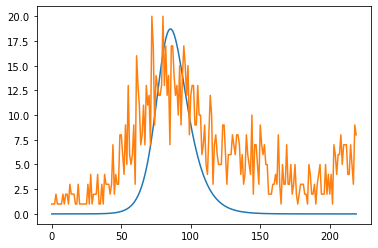

In [47]:
dS, dE, dI, dR, dD = run_model(out.params, x)
plt.plot(dI)
plt.plot(data)

In [48]:
report_fit(out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 149
    # data points      = 220
    # variables        = 2
    chi-square         = 5119.06634
    reduced chi-square = 23.4819557
    Akaike info crit   = 696.361956
    Bayesian info crit = 703.149211
[[Variables]]
    S0:     2721999 (fixed)
    E0:     1 (fixed)
    I0:     0 (fixed)
    R0:     0 (fixed)
    D0:     0 (fixed)
    N:      2722000 (fixed)
    beta:   6767.42243 +/- 353.843527 (5.23%) (init = 1.333333)
    gamma:  4954.96928 +/- 236.603756 (4.78%) (init = 0.3333333)
    delta:  0.2 (fixed)
    tay:    0.26 (fixed)
    khi:    0.05555556 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.994


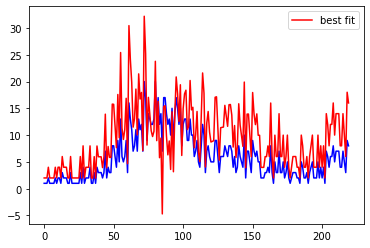

In [49]:
plt.plot(x, data, 'b')
plt.plot(x, get_residual(out.params, data, x) + data, 'r', label='best fit')
plt.legend(loc='best')
plt.show()

In [50]:
S0 = out.params['S0'].value
E0 = out.params['E0'].value
I0 = out.params['I0'].value
R0 = out.params['R0'].value
D0 = out.params['D0'].value
N = out.params['N'].value
beta = out.params['beta'].value
gamma = out.params['gamma'].value
delta = out.params['delta'].value
tay = out.params['tay'].value
khi = out.params['khi'].value

y0 = S0, E0, I0, R0, D0

ret = odeint(deriv, y0, x, args=(N, beta, gamma, delta, tay, khi))
dS, dE, dI, dR, dD = ret.T

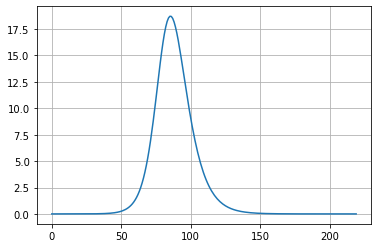

In [51]:
plt.plot(x, dI)
plt.grid('True')

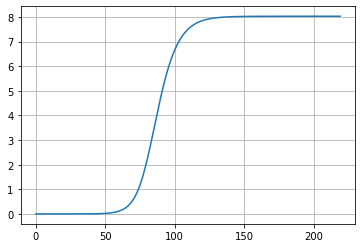

In [52]:
plt.plot(x, dD)
plt.grid('True')